# Histopathologic Cancer Detection


## 1. Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Set random seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

# Check GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE

2026-01-08 19:08:21.657295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767899301.851907      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767899301.909662      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767899302.375505      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767899302.375548      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767899302.375552      24 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 2. Configuration

In [2]:
# Hyperparameters
IMG_SIZE = 96
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001
VAL_SPLIT = 0.2

# Data paths
TRAIN_DIR = '/kaggle/input/histopathologic-cancer-detection/train/'
TEST_DIR = '/kaggle/input/histopathologic-cancer-detection/test/'
LABELS_PATH = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
SAMPLE_SUB_PATH = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'

print("Configuration:")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Validation Split: {VAL_SPLIT}")

Configuration:
  Image Size: 96x96
  Batch Size: 64
  Epochs: 20
  Learning Rate: 0.001
  Validation Split: 0.2


## 3. Exploratory Data Analysis (EDA)

In [3]:
# Load labels
train_labels = pd.read_csv(LABELS_PATH)
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

print("Training Labels Preview:")
display(train_labels.head())
print(f"\nDataset Size: {len(train_labels):,} images")

Training Labels Preview:


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


Dataset Size: 220,025 images


In [4]:
# Data quality check
print("Data Quality Check:")
print(f"  Null Values: {train_labels.isnull().sum().sum()}")
print(f"  Duplicate IDs: {train_labels.duplicated(subset=['id']).sum()}")
print(f"  Invalid Labels: {len(train_labels[(train_labels['label'] != 0) & (train_labels['label'] != 1)])}")

Data Quality Check:
  Null Values: 0
  Duplicate IDs: 0
  Invalid Labels: 0


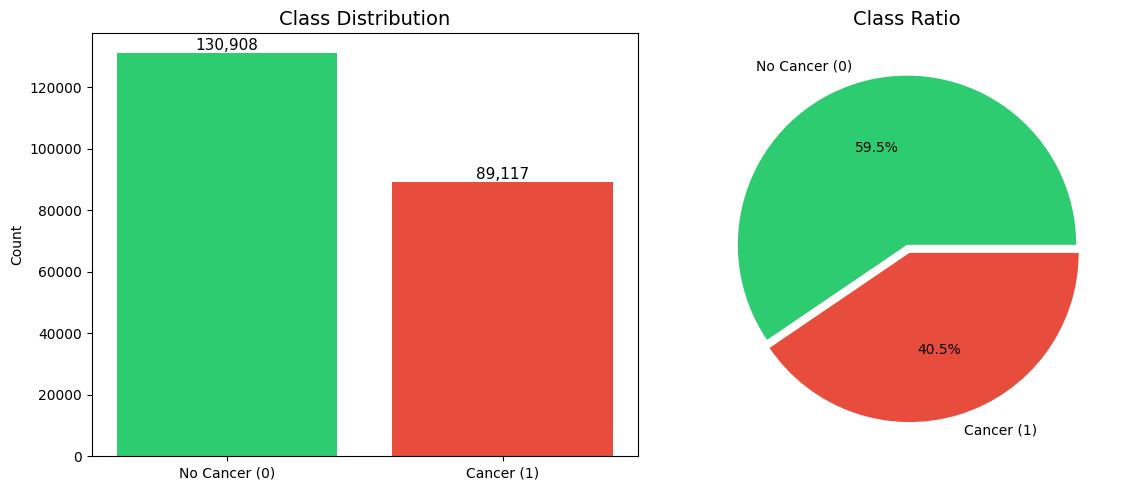


Class Distribution:
  No Cancer (0): 130,908 (59.5%)
  Cancer (1): 89,117 (40.5%)


In [5]:
# Class distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
colors = ['#2ecc71', '#e74c3c']
class_counts = train_labels['label'].value_counts().sort_index()
axes[0].bar(['No Cancer (0)', 'Cancer (1)'], class_counts.values, color=colors)
axes[0].set_title('Class Distribution', fontsize=14)
axes[0].set_ylabel('Count')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', fontsize=11)

# Pie chart
axes[1].pie(class_counts.values, labels=['No Cancer (0)', 'Cancer (1)'], 
            autopct='%1.1f%%', colors=colors, explode=(0, 0.05))
axes[1].set_title('Class Ratio', fontsize=14)

plt.tight_layout()
plt.show()

print(f"\nClass Distribution:")
print(f"  No Cancer (0): {class_counts[0]:,} ({class_counts[0]/len(train_labels)*100:.1f}%)")
print(f"  Cancer (1): {class_counts[1]:,} ({class_counts[1]/len(train_labels)*100:.1f}%)")

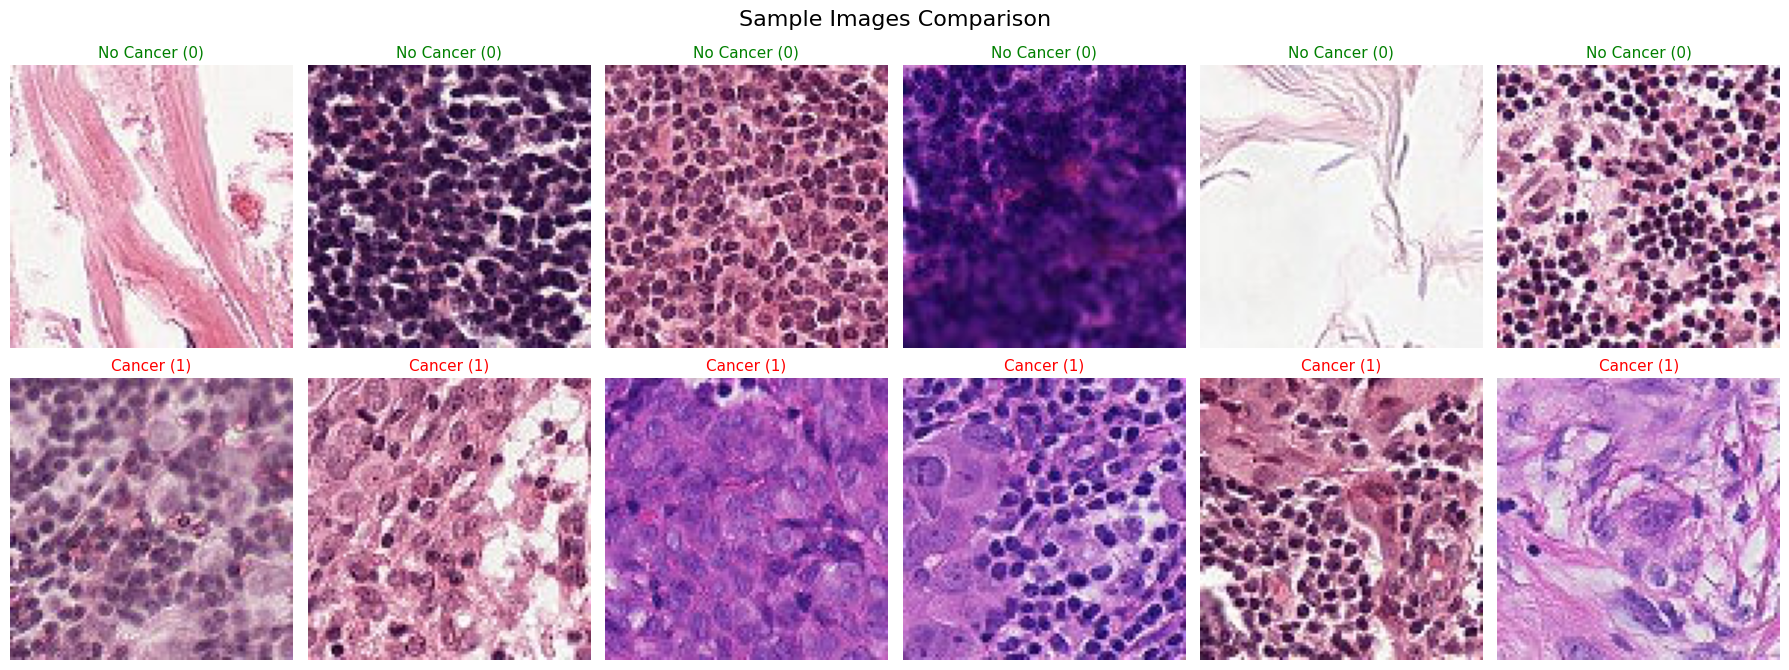

In [6]:
# Visualize sample images
def show_sample_images(labels_df, train_dir, n_samples=6):
    fig, axes = plt.subplots(2, n_samples, figsize=(18, 7))
    
    # No cancer samples (label=0)
    no_cancer = labels_df[labels_df['label'] == 0].sample(n_samples, random_state=42)
    for i, (idx, row) in enumerate(no_cancer.iterrows()):
        img_path = os.path.join(train_dir, row['id'] + '.tif')
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title('No Cancer (0)', fontsize=11, color='green')
        axes[0, i].axis('off')
    
    # Cancer samples (label=1)
    cancer = labels_df[labels_df['label'] == 1].sample(n_samples, random_state=42)
    for i, (idx, row) in enumerate(cancer.iterrows()):
        img_path = os.path.join(train_dir, row['id'] + '.tif')
        img = Image.open(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title('Cancer (1)', fontsize=11, color='red')
        axes[1, i].axis('off')
    
    plt.suptitle('Sample Images Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images(train_labels, TRAIN_DIR)

In [7]:
# Check image properties
sample_img_path = os.path.join(TRAIN_DIR, train_labels.iloc[0]['id'] + '.tif')
sample_img = Image.open(sample_img_path)
print(f"Image Size: {sample_img.size}")
print(f"Image Mode: {sample_img.mode}")

Image Size: (96, 96)
Image Mode: RGB


## 4. Data Pipeline with tf.data

In [8]:
# Prepare file paths and labels
train_labels['file_path'] = train_labels['id'].apply(lambda x: TRAIN_DIR + x + '.tif')

# Split into train and validation sets
train_df, val_df = train_test_split(
    train_labels, 
    test_size=VAL_SPLIT, 
    random_state=42, 
    stratify=train_labels['label']
)

print(f"Training Set Size: {len(train_df):,}")
print(f"Validation Set Size: {len(val_df):,}")

Training Set Size: 176,020
Validation Set Size: 44,005


In [9]:
# Image loading function
def load_image(file_path, label):
    # Read and decode image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    return img, label

# Data augmentation function (for training only)
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    # Random rotation (0, 90, 180, or 270 degrees)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    # Ensure values are still in [0, 1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, label

print("Image loading and augmentation functions defined.")

Image loading and augmentation functions defined.


In [10]:
import cv2

def load_image(file_path, label):
    """Load TIF image using tf.py_function wrapper"""
    def _load_image_py(path):
        # Read image using OpenCV (supports TIF)
        path_str = path.numpy().decode('utf-8')
        img = cv2.imread(path_str)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        return img
    
    # Use tf.py_function to wrap the Python function
    img = tf.py_function(_load_image_py, [file_path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])  # Set shape explicitly
    return img, label

def augment(img, label):
    """Data augmentation"""
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    # Random rotation (0, 90, 180, or 270 degrees)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    # Clip values to [0, 1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, label

print("Image loading functions defined (TIF support enabled)")


Image loading functions defined (TIF support enabled)


In [11]:
# Create training dataset
train_files = train_df['file_path'].values
train_labels_arr = train_df['label'].values.astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels_arr))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(AUTOTUNE)

# Create validation dataset (no augmentation)
val_files = val_df['file_path'].values
val_labels_arr = val_df['label'].values.astype(np.float32)

val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels_arr))
val_dataset = val_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(AUTOTUNE)

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")

I0000 00:00:1767899318.110547      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767899318.111434      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training batches: 2751
Validation batches: 688


In [12]:
def show_augmented_images(dataset, n_samples=6):
    """Visualize augmented training images"""
    fig, axes = plt.subplots(2, n_samples, figsize=(18, 7))
    
    # Get one batch
    for images, labels in dataset.take(1):
        for i in range(min(n_samples, len(images))):
            axes[0, i].imshow(images[i])
            title = 'Cancer' if labels[i] == 1 else 'No Cancer'
            color = 'red' if labels[i] == 1 else 'green'
            axes[0, i].set_title(f'{title}', fontsize=11, color=color)
            axes[0, i].axis('off')
    
    # Get another batch to show variety
    for images, labels in dataset.take(1):
        for i in range(min(n_samples, len(images))):
            axes[1, i].imshow(images[i])
            title = 'Cancer' if labels[i] == 1 else 'No Cancer'
            color = 'red' if labels[i] == 1 else 'green'
            axes[1, i].set_title(f'{title}', fontsize=11, color=color)
            axes[1, i].axis('off')
    
    plt.suptitle('Augmented Training Images', fontsize=16)
    plt.tight_layout()
    plt.show()

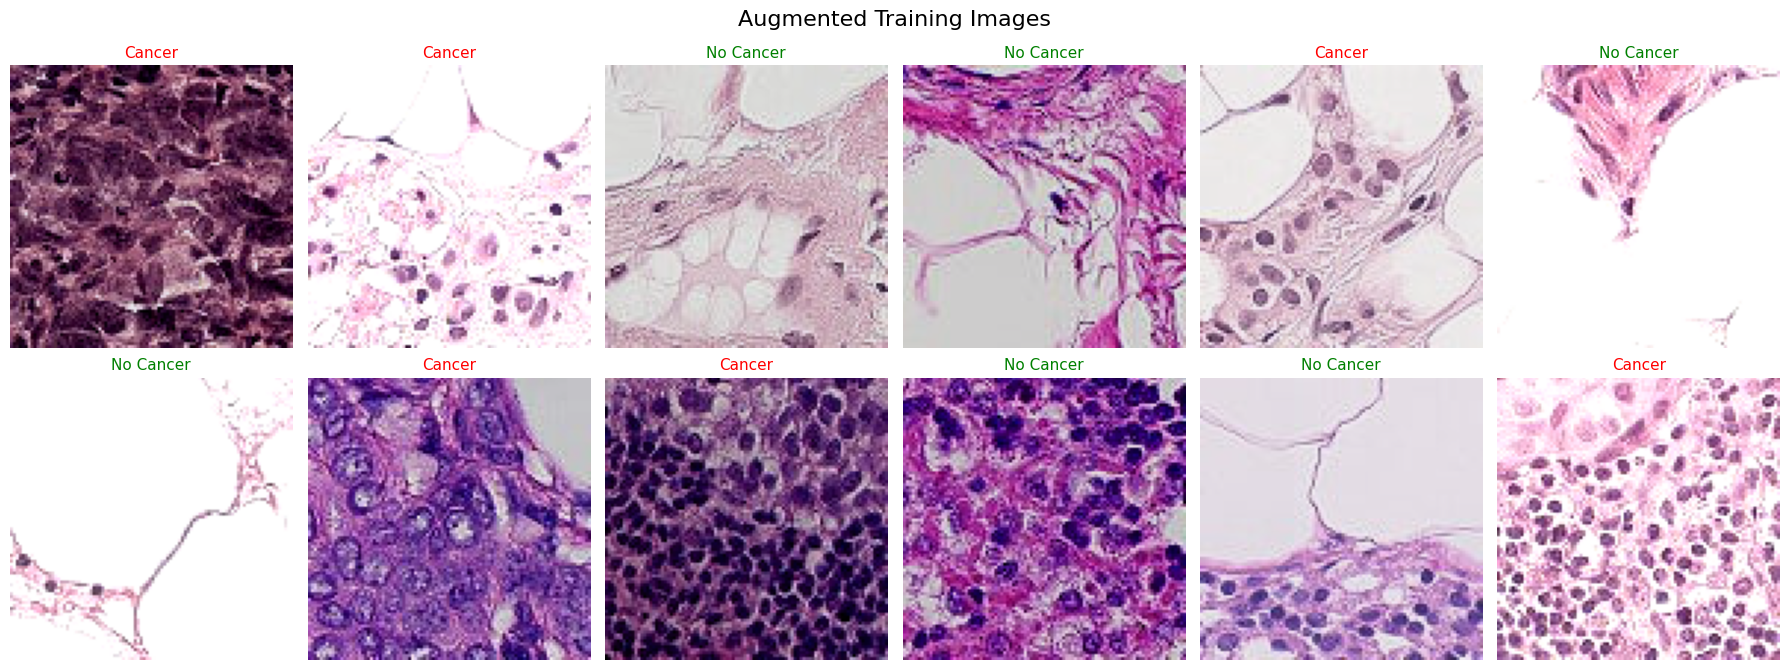

In [13]:
# Visualize augmented images
show_augmented_images(train_dataset)

## 5. Model Architecture - Custom CNN

In [14]:
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    """
    Create a custom CNN model for binary classification.
    Architecture: 3 Conv blocks + Fully connected layers
    """
    model = models.Sequential([
        # Input layer
        layers.InputLayer(input_shape=input_shape),
        
        # Block 1: 32 filters
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2: 64 filters
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3: 128 filters
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 4: 256 filters
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Create model
model = create_cnn_model()

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,963,553 (22.75 MB)

 Trainable params: 5,960,353 (22.74 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [15]:
# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"Model: Custom Sequential CNN")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-trainable Parameters: {non_trainable_params:,}")

Model: Custom Sequential CNN
Total Parameters: 5,963,553
Trainable Parameters: 5,960,353
Non-trainable Parameters: 3,200


## 6. Compile Model

In [16]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print("Model compiled successfully!")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Loss: Binary Cross-Entropy")
print(f"  Metrics: Accuracy, AUC, Precision, Recall")

Model compiled successfully!
  Optimizer: Adam (lr=0.001)
  Loss: Binary Cross-Entropy
  Metrics: Accuracy, AUC, Precision, Recall


## 7. Define Callbacks

In [17]:
# Define callbacks
model_callbacks = [
    # Early stopping: Stop training if val_auc doesn't improve
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=5,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when val_loss plateaus
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save the best model
    callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks defined:")
print("  - EarlyStopping (patience=5, monitor=val_auc)")
print("  - ReduceLROnPlateau (factor=0.5, patience=3)")
print("  - ModelCheckpoint (save best model)")

Callbacks defined:
  - EarlyStopping (patience=5, monitor=val_auc)
  - ReduceLROnPlateau (factor=0.5, patience=3)
  - ModelCheckpoint (save best model)


## 8. Train the Model

In [18]:
# print("Starting training...")
# print("=" * 60)

# history = model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data=val_dataset,
#     callbacks=model_callbacks,
#     verbose=1
# )

# print("\n" + "=" * 60)
# print("Training completed!")

# model.save('/kaggle/working/best_model.keras')
# print("Model saved to /kaggle/working/best_model.keras")

In [19]:
import os
print(os.listdir('/kaggle/input'))

['histopathologic-cancer-detection', 'cancer-detection-model']


In [20]:
from tensorflow.keras.models import load_model
best_model = load_model('/kaggle/input/cancer-detection-model/best_model.keras')
print("✅ Best model loaded successfully!")
best_model.summary()

✅ Best model loaded successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,884,261 (68.22 MB)

 Trainable params: 5,960,353 (22.74 MB)

 Non-trainable params: 3,200 (12.50 KB)

 Optimizer params: 11,920,708 (45.47 MB)

## 10. Evaluate Model on Validation Set

In [21]:
print("\n" + "="*50)
print("Evaluating on Validation Set...")
print("="*50)

val_results = best_model.evaluate(val_dataset, verbose=1)
print(f"\nValidation Results:")
print(f"  Loss: {val_results[0]:.4f}")
print(f"  Accuracy: {val_results[1]:.4f}")
print(f"  AUC: {val_results[2]:.4f}")
print(f"  Precision: {val_results[3]:.4f}")
print(f"  Recall: {val_results[4]:.4f}")


Evaluating on Validation Set...


I0000 00:00:1767899327.963508      69 service.cc:152] XLA service 0x7b381800a560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767899327.963557      69 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767899327.963564      69 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767899328.341649      69 cuda_dnn.cc:529] Loaded cuDNN version 91002


  4/688 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9609 - auc: 0.9915 - loss: 0.1198 - precision: 0.9050 - recall: 0.9974

I0000 00:00:1767899331.397281      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


688/688 ━━━━━━━━━━━━━━━━━━━━ 148s 209ms/step - accuracy: 0.9618 - auc: 0.9915 - loss: 0.1089 - precision: 0.9479 - recall: 0.9585

Validation Results:
  Loss: 0.1066
  Accuracy: 0.9627
  AUC: 0.9917
  Precision: 0.9501
  Recall: 0.9581


688/688 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step

ROC-AUC Score: 0.9918

Classification Report:
               precision    recall  f1-score   support

No Cancer (0)       0.97      0.97      0.97     26182
   Cancer (1)       0.95      0.96      0.95     17823

     accuracy                           0.96     44005
    macro avg       0.96      0.96      0.96     44005
 weighted avg       0.96      0.96      0.96     44005



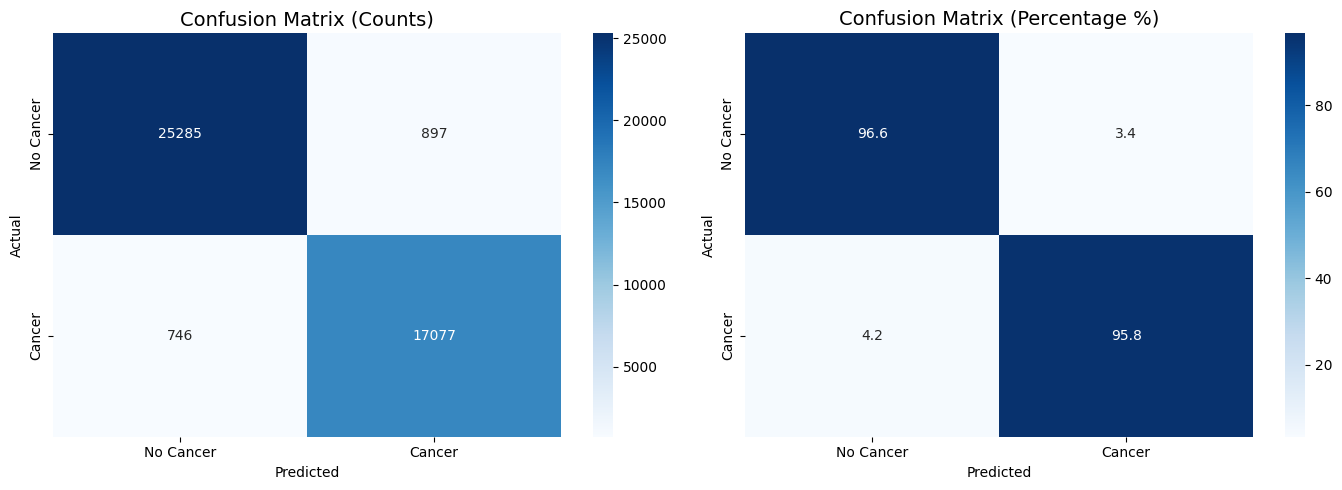

In [22]:
#Confusion Matrix and Classification Report
def evaluate_model_detailed(model, dataset, df):
    """Detailed model performance evaluation"""
    # Get predictions
    y_pred_proba = model.predict(dataset, verbose=1)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    y_true = df['label'].values
    
    # Calculate AUC
    auc_score = roc_auc_score(y_true, y_pred_proba)
    print(f"\nROC-AUC Score: {auc_score:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Cancer (0)', 'Cancer (1)']))
    
    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion matrix - Counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['No Cancer', 'Cancer'],
                yticklabels=['No Cancer', 'Cancer'])
    axes[0].set_title('Confusion Matrix (Counts)', fontsize=14)
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # Confusion matrix - Percentage
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=axes[1],
                xticklabels=['No Cancer', 'Cancer'],
                yticklabels=['No Cancer', 'Cancer'])
    axes[1].set_title('Confusion Matrix (Percentage %)', fontsize=14)
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150)
    plt.show()
    
    return y_pred_proba, y_pred

# Detailed evaluation
val_pred_proba, val_pred = evaluate_model_detailed(best_model, val_dataset, val_df)


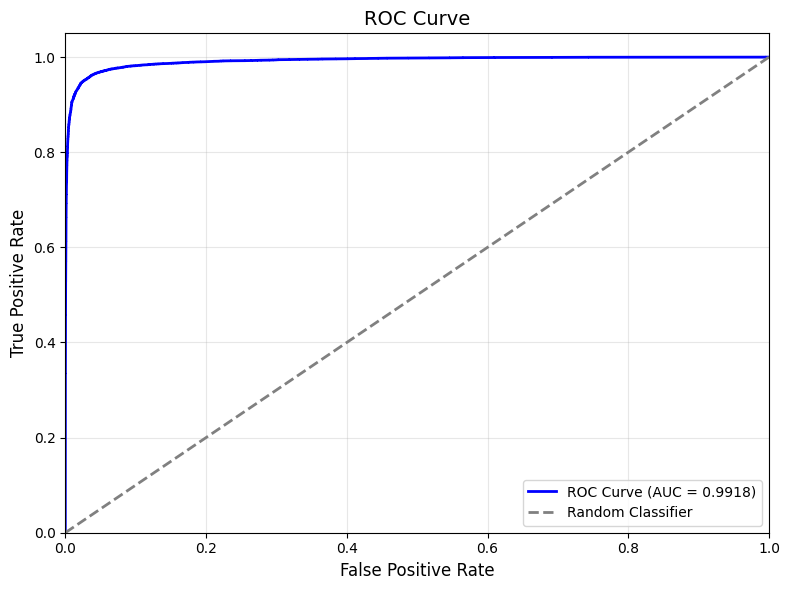

In [23]:
# 4. ROC Curve Visualization
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba):
    """Plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curve.png', dpi=150)
    plt.show()

plot_roc_curve(val_df['label'].values, val_pred_proba)

## 11. Generate Test Predictions

In [24]:
print("\n" + "="*50)
print("Generating Test Predictions...")
print("="*50)

# Get test file list
test_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith('.tif')]
test_ids = [os.path.splitext(os.path.basename(f))[0] for f in test_files]

print(f"Total test images: {len(test_files):,}")

# Create test dataset
def load_test_image(file_path):
    """Load test image"""
    def _load_image_py(path):
        path_str = path.numpy().decode('utf-8')
        img = cv2.imread(path_str)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0
        return img
    
    img = tf.py_function(_load_image_py, [file_path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return img

# Build test dataset pipeline
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(AUTOTUNE)

print(f"Test batches: {len(test_dataset)}")

# Generate predictions
test_predictions = best_model.predict(test_dataset, verbose=1)
test_predictions = test_predictions.flatten()

print(f"Predictions generated: {len(test_predictions):,}")


Generating Test Predictions...
Total test images: 57,458
Test batches: 898
898/898 ━━━━━━━━━━━━━━━━━━━━ 185s 205ms/step
Predictions generated: 57,458


## 12. Create Submission File


Submission file created!

Submission Preview:
                                         id     label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5  0.000029
1  95596b92e5066c5c52466c90b69ff089b39f2737  0.084693
2  248e6738860e2ebcf6258cdc1f32f299e0c76914  0.000001
3  2c35657e312966e9294eac6841726ff3a748febf  0.001794
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6  0.018922
5  725dabe6ecccc68b958a2c7dd75bcbf362c7cb03  0.991429
6  aa0307865281d4484ddf8c637c348292968b93a7  0.374199
7  f4e5dc9c949920f1b3362982e15e99bf6f3ef83b  0.576925
8  95e08c9cedc28a9b4a86f4fc1e06c1972134be08  0.000137
9  ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb  0.004087

Submission Statistics:
  Total samples: 57,458
  Mean prediction: 0.3768
  Std prediction: 0.4353
  Min prediction: 0.0000
  Max prediction: 1.0000


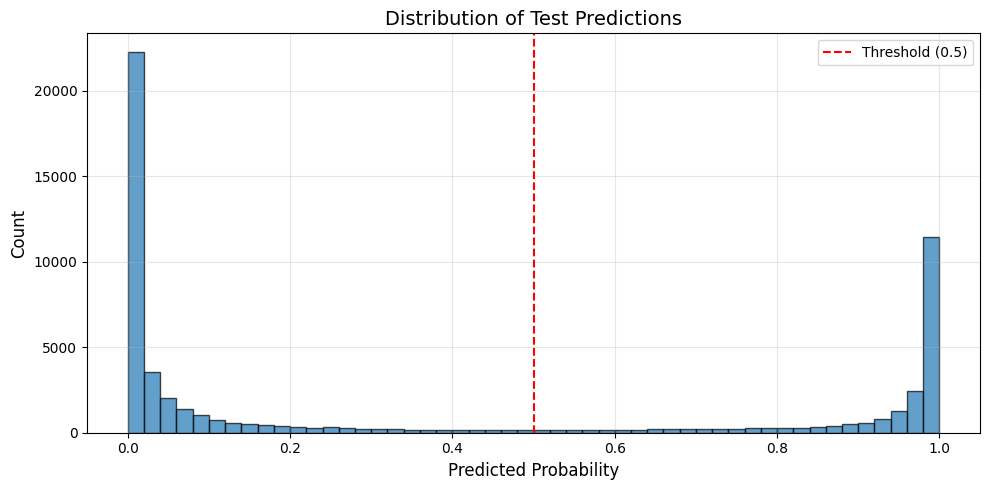


High Confidence Predictions:
  Confident No Cancer (< 0.2): 32,968
  Confident Cancer (> 0.8): 18,351
  Uncertain (0.4 - 0.6): 1,685

✅ All done! Submit 'submission.csv' to Kaggle.


In [25]:
submission = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions
})

# Reorder according to sample_submission
submission = submission.set_index('id').loc[sample_submission['id']].reset_index()

# Save submission file
submission.to_csv('submission.csv', index=False)

print("\n" + "="*50)
print("Submission file created!")
print("="*50)
print(f"\nSubmission Preview:")
print(submission.head(10))
print(f"\nSubmission Statistics:")
print(f"  Total samples: {len(submission):,}")
print(f"  Mean prediction: {submission['label'].mean():.4f}")
print(f"  Std prediction: {submission['label'].std():.4f}")
print(f"  Min prediction: {submission['label'].min():.4f}")
print(f"  Max prediction: {submission['label'].max():.4f}")

# Prediction distribution visualization
plt.figure(figsize=(10, 5))
plt.hist(submission['label'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Test Predictions', fontsize=14)
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=150)
plt.show()

# High confidence prediction statistics
print(f"\nHigh Confidence Predictions:")
print(f"  Confident No Cancer (< 0.2): {(submission['label'] < 0.2).sum():,}")
print(f"  Confident Cancer (> 0.8): {(submission['label'] > 0.8).sum():,}")
print(f"  Uncertain (0.4 - 0.6): {((submission['label'] >= 0.4) & (submission['label'] <= 0.6)).sum():,}")

print("\n✅ All done! Submit 'submission.csv' to Kaggle.")